# Ancestry-specific tagging in admixed individuals


In [1]:
import admix
import os
import matplotlib.pyplot as plt
import numpy as np

## Simulate admixed individuals with African-European admixed ancestries

In [2]:
# specify reference data sets
dset_dir = admix.dataset.get_test_data_dir()
ref_dset = admix.io.read_dataset(os.path.join(dset_dir, "toy-all"))
ref_dset_list = [
    ref_dset[:, (ref_dset.indiv.SuperPop == pop).values] for pop in ["EUR", "AFR"]
]

In [3]:
# simulate 8 generations
n_indiv = 5000

mosaic_size = admix.simulate.calculate_mosaic_size(
    ref_dset.snp, "hg38", chrom=22, n_gen=8
)

np.random.seed(1234)
dset = admix.simulate.admix_geno(
    geno_list=[dset.geno for dset in ref_dset_list],
    df_snp=ref_dset_list[0].snp,
    n_indiv=n_indiv,
    anc_props=[0.5, 0.5],
    mosaic_size=mosaic_size,
)

2024-02-14 18:43:45 [info     ] genetic_map not found at /home/runner/work/admix-kit/admix-kit/admix/../.admix_cache/data/genetic_map/genetic_map_hg38_withX.txt.gz.


2024-02-14 18:43:45 [info     ] Downloading genetic_map from https://storage.googleapis.com/broad-alkesgroup-public/Eagle/downloads/tables/genetic_map_hg38_withX.txt.gz.


2024-02-14 18:43:45 [info     ] If this gets stuck or fails, manually download https://storage.googleapis.com/broad-alkesgroup-public/Eagle/downloads/tables/genetic_map_hg38_withX.txt.gz to /home/runner/work/admix-kit/admix-kit/admix/../.admix_cache/data/genetic_map/genetic_map_hg38_withX.txt.gz.


  0%|          | 0/10000 [00:00<?, ?it/s]

 35%|███▌      | 3516/10000 [00:00<00:00, 35150.06it/s]

 70%|███████   | 7039/10000 [00:00<00:00, 35194.48it/s]

100%|██████████| 10000/10000 [00:00<00:00, 35244.21it/s]

/home/runner/work/admix-kit/admix-kit/admix/plot/_plot.py:345: UserWarning: Only the first 10 are plotted. To plot more individuals, increase `max_indiv`
  warnings.warn(


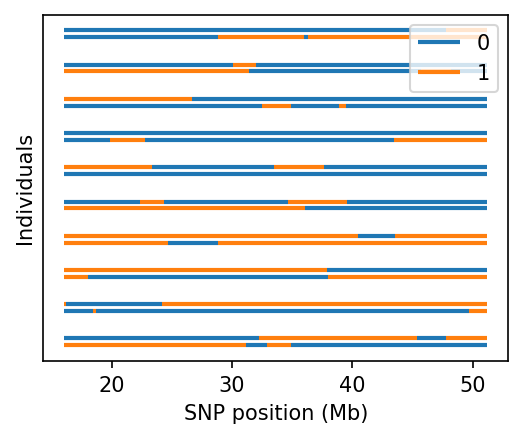

In [4]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)
admix.plot.lanc(dset, ax=ax)

In [5]:
dset.snp[["EUR_FREQ", "AFR_FREQ"]] = dset.af_per_anc()

admix.data.af_per_anc:   0%|          | 0/1 [00:00<?, ?it/s]

admix.data.af_per_anc: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

admix.data.af_per_anc: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

In [6]:
dset = dset[
    (
        (dset.snp.EUR_FREQ.between(0.01, 0.99))
        & (dset.snp.AFR_FREQ.between(0.01, 0.99))
    ).values
]
display(dset)

admix.Dataset object with n_snp x n_indiv = 1091 x 5000, n_anc=2
	snp: 'CHROM', 'POS', 'REF', 'ALT', 'EUR_FREQ', 'AFR_FREQ'

## Math expression for ancestry-specific tagging
We first assume the phenotype has a single causal variant $s$, and phenotype can be modeled as
$$
\mathbf{y} = \mathbf{g}_{s,1} \boldsymbol{\beta}_{s, 1} + \mathbf{g}_{s,2} \boldsymbol{\beta}_{s,2} + \boldsymbol{\epsilon},
$$
where $\mathbf{g}_{s,\cdot}$ denote the genotype for each local ancestry, and $\boldsymbol{\beta}_{s,\cdot}$ denote the allelic effect sizes for each local ancestry. The above equation can be rewritten for notation convenience, as

$$
\mathbf{y} = \mathbf{G}_s \boldsymbol{\beta}_s + \boldsymbol{\epsilon},
$$

where we denote 
$$
\mathbf{G}_s:= \left[
    \begin{smallmatrix}
        \vert     & \vert     \\
        \mathbf{g}_{s, 1} & \mathbf{g}_{s, 2} \\
        \vert     & \vert
    \end{smallmatrix}
    \right] \in \mathbb{R}^{N \times 2}
$$ and
$$
\boldsymbol{\beta}_s =
\begin{bmatrix}
    \beta_{s, 1} \\
    \beta_{s, 2}
\end{bmatrix} \in \mathbb{R}^{2 \times 1}.
$$
    
Now we consider another tagging variant $t$, we ask what would be the ancestry-specific marginal effects evaluated at the tagging variant $t$ if the causal effects are the same across ancestries at variant $s$?

Based on linear regression, the estimated effects at $t$ are
$$
    \widehat{\boldsymbol{\beta}_t} = (\mathbf{G}_t^\top \mathbf{G}_t)^{-1} \mathbf{G}_t^\top \mathbf{y}.
$$
And the expectation of estimated effects are
$$
\mathbb{E}[\widehat{\boldsymbol{\beta}_t}] = (\mathbf{G}_t^\top \mathbf{G}_t)^{-1} \mathbf{G}_t^\top \mathbf{G}_s \boldsymbol{\beta}_s
$$
Because by assumption, $\boldsymbol{\beta}_{s,1} = \boldsymbol{\beta}_{s,2} = \beta_s$, the above expectation can be simplified as
$$
\mathbb{E}[\widehat{\boldsymbol{\beta}_t}] = (\mathbf{G}_t^\top \mathbf{G}_t)^{-1} \mathbf{G}_t^\top \mathbf{g}_s \beta_s
$$
Therefore, $(\mathbf{G}_t^\top \mathbf{G}_t)^{-1} \mathbf{G}_t^\top \mathbf{g}_s$ is the key quantity here.

## Implementation
The following code `admix_tagging` calculate this quantity

In [7]:
def admix_tagging(admix_ld, s: int, t: int):
    """
    Assuming the causal SNP s, calculate the tagging from SNP s to SNP t

    Parameters
    ----------
    admix_ld: Dict
        calculated by admix.data.admix_ld
    s: int
        source SNP
    t: int
        target SNP
    """

    def GG(admix_ld, s, t):
        ld1, ld2, ld12 = admix_ld["11"], admix_ld["22"], admix_ld["12"]
        return np.array([[ld1[s, t], ld12[s, t]], [ld12[t, s], ld2[s, t]]])

    GtGt = GG(admix_ld, t, t)
    GtGs = GG(admix_ld, t, s)
    tag = np.linalg.inv(GtGt) @ GtGs @ np.ones(2)[:, None]
    return tag.flatten()

In [8]:
print(admix.data.admix_ld.__doc__)

Calculate ancestry specific LD matrices

    Parameters
    ----------
    dset: admix.Dataset
        dataset containing geno, lanc
    cov : Optional[np.ndarray]
        (n_indiv, n_cov) covariates of the genotypes, an all `1` intercept covariate will always be added
        so there is no need to add the intercept in covariates.
    Returns
    -------
    K1: np.ndarray
        ancestry specific LD matrix for the 1st ancestry
    K2: np.ndarray
        ancestry specific LD matrix for the 2nd ancestry
    K12: np.ndarray
        ancestry specific LD matrix for cross term of the 1st and 2nd ancestry
    


In [9]:
# precompute once
# you can optionally control for some covariates
admix_ld = admix.data.admix_ld(dset, cov=None)

In [10]:
# causal SNP 1, tagging SNP 0
admix_tagging(admix_ld, s=1, t=0)

array([ 0.25264469, -0.08786723])

Now we calculate the ancestry-specific taggability for every target SNP $i$ from potential causal SNP $i + 1$.

In [11]:
res = []
for i in range(dset.n_snp - 1):
    res.append(admix_tagging(admix_ld, s=i, t=i + 1))
res = np.vstack(res)

Text(0, 0.5, 'Tag for ancestry 2')

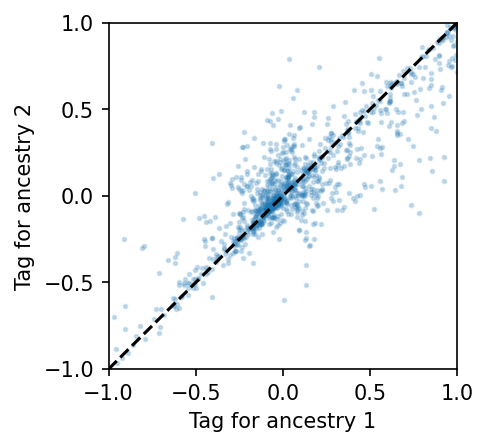

In [12]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
ax.scatter(res[:, 0], res[:, 1], s=3, alpha=0.2)
lim = max(abs(res.max()), abs(res.min()))
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.plot((-lim, lim), (-lim, lim), "k--")
ax.set_xlabel("Tag for ancestry 1")
ax.set_ylabel("Tag for ancestry 2")